In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams['axes.grid'] = False

#### CIFAR10

In [4]:
data_transforms = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,transform=data_transforms)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,transform=data_transforms)

Files already downloaded and verified


### Baseline

conv3x3(n) -> conv3x3(n) -> max_pool -> conv3x3(1.5 n) -> conv3x3(1.5 n) -> max_pool -> conv3x3(2 n) ->  conv3x3(2 n)  -> global_pool (or just flatten)-> dense(10, nonlinearity = softmax)

In [0]:
# Glorot (Xavier) initialization
def init_weights(m):
    if isinstance(m, (nn.Conv2d,nn.Linear)):
        nn.init.xavier_uniform_(m.weight)

In [0]:
class Network(nn.Module):
    def __init__(self, n):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, n, 3)
        self.conv2 = nn.Conv2d(n, n, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(n, int(1.5*n), 3)
        self.conv4 = nn.Conv2d(int(1.5*n), int(1.5*n), 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(int(1.5*n), 2*n, 3)
        self.conv6 = nn.Conv2d(2*n, 2*n, 3)
        self.dense = nn.Linear(2*n, 10)
        self.nonlinearity = nn.LeakyReLU(negative_slope=0.01)
        self.apply(init_weights)

    def forward(self, x):
        x = self.nonlinearity(self.conv1(x))
        x = self.nonlinearity(self.conv2(x))
        x = self.pool1(x)
        x = self.nonlinearity(self.conv3(x))
        x = self.nonlinearity(self.conv4(x))
        x = self.pool2(x)
        x = self.nonlinearity(self.conv5(x))
        x = self.nonlinearity(self.conv6(x))
        # global pooling
        x = x.view(x.shape[0], x.shape[1], -1).mean(-1) # in this case H,W = 1, so it just reduces dims
        x = self.dense(x) #logits
        return x

In [0]:
def plot(hist):
    clear_output(True)
    h = np.array(hist)
    plt.plot(h[:,0], h[:,1],label='loss')
    plt.legend()
    plt.show()

In [0]:
def train(model,opt,criterion,n_epochs, batch_size,trainset):
    model.train()
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
    hist = []
    best_state = model.state_dict()
    best_loss = 999999
    for epoch in range(n_epochs):
        total_loss = 0.0
        correct = 0.0
        for i, data in enumerate(trainloader, 0):
            model.zero_grad()
            inputs, labels = data[0].to(model.device), data[1].to(device)
            logits = net(inputs)
            loss = criterion(logits,labels)
            loss.backward()
            opt.step()
            total_loss += loss.data.cpu().numpy()
            _, predicted = torch.max(logits.data, 1)
            correct += (predicted == labels).sum().data.cpu().numpy()
            if i % 30 == 29:    # print every 30 mini-batches
                total_loss /= 30
                hist.append([epoch + i/len(trainloader), total_loss ])
                plot(hist)
                print("Loss: " + str(total_loss))
                print("Accuracy: " + str(correct/30/batch_size))
                if total_loss < best_loss:
                    best_state = model.state_dict()
                total_loss = 0.0
                correct = 0.0
    model.load_state_dict(best_state)
    return model

In [0]:
def test(model,batch_size,testset):
    model.eval()
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
    correct = 0.0
    for data in testloader:
        inputs, labels = data[0].to(model.device), data[1].to(device)
        logits = net(inputs).detach()
        _, predicted = torch.max(logits.data, 1)
        correct += (predicted == labels).sum().cpu().numpy()
    print("Accuracy on the test set: " + str(correct/len(testset)))

In [0]:
n = 20
device = torch.device("cuda")

In [0]:
net = Network(n)
net.device = device
net.to(net.device)
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

In [0]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(pytorch_total_params)
print(len(trainset))

43430
50000


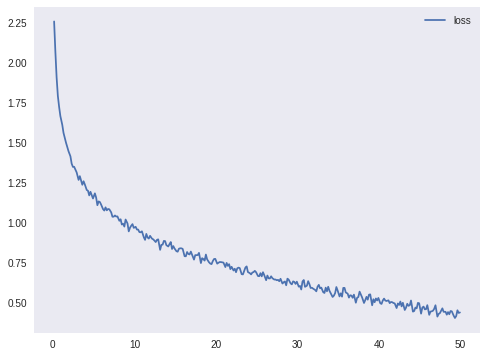

Loss: 0.4341768890619278
Accuracy: 0.8440104166666667


In [0]:
net = train(net,opt,criterion,50,256,trainset)

In [0]:
test(net,256,testset)

Accuracy on the test set: 0.7046


### Sigmoid nonlinearity

In [0]:
net.apply(init_weights)
net.nonlinearity = nn.Sigmoid()

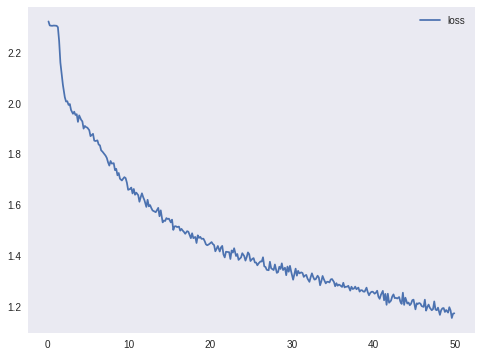

Loss: 1.1711900353431701
Accuracy: 0.5811197916666667


In [0]:
net = train(net,opt,criterion,50,256,trainset)

In [0]:
test(net,256,testset)

Accuracy on the test set: 0.5588


Net with Sigmoid nonlinearity converges worse

### ELU nonlinearity

In [0]:
net.apply(init_weights)
net.nonlinearity = nn.ELU()

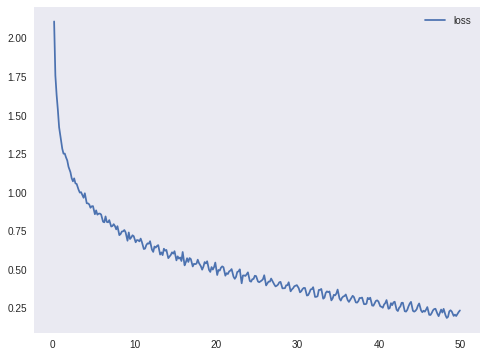

Loss: 0.232414277891318
Accuracy: 0.9153645833333334


In [0]:
net = train(net,opt,criterion,50,256,trainset)

In [0]:
test(net,256,testset)

Accuracy on the test set: 0.6934


Net with ELU nonlinearity converges even better than with LeakyReLU but it's heavily overfitted.

### BlockConv2D layer

Write your own BlockConv2D layer (http://lasagne.readthedocs.io/en/latest/user/custom_layers.html),
by introducing a binary constant mask M (make sure it is not a learnable parameter) and replacing kernel W (https://github.com/Lasagne/Lasagne/blob/master/lasagne/layers/conv.py#L607) with M[:, :, None, None] * W,
so that a single conv filter can use at most k incoming channels, e.g. 1-st filter can use only first 4 channels, 2nd only channels trough 2nd to 5th etc.
In general, i-th filter can use incoming channels trough i % n to (i + k) % n, where n is the number of incoming channels.

In [0]:
from torch.nn.parameter import Parameter
from torch.nn.modules.utils import _pair

class BlockConv2d(nn.modules.conv._ConvNd):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True, k=4):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(BlockConv2d, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias)
        self.mask = Parameter(self.get_mask(k), requires_grad=False)
            
            
    def get_mask(self,k):
        mask = torch.zeros(self.weight.shape,requires_grad=False)
        for i in range(self.out_channels):
            mask[i, [(j % self.in_channels) for j in range(i,i+k)] , :, :] = 1
        return mask
            
        
    def forward(self, input):
        return F.conv2d(input, self.mask*self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

In [0]:
class Network_BlockConv(nn.Module):
    def __init__(self, n):
        super(Network_BlockConv, self).__init__()
        self.conv1 = BlockConv2d(3, n, 3)
        self.conv2 = BlockConv2d(n, n, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = BlockConv2d(n, int(1.5*n), 3)
        self.conv4 = BlockConv2d(int(1.5*n), int(1.5*n), 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = BlockConv2d(int(1.5*n), 2*n, 3)
        self.conv6 = BlockConv2d(2*n, 2*n, 3)
        self.dense = nn.Linear(2*n, 10)
        self.nonlinearity = nn.LeakyReLU(negative_slope=0.01)
        self.apply(init_weights)

    def forward(self, x):
        x = self.nonlinearity(self.conv1(x))
        x = self.nonlinearity(self.conv2(x))
        x = self.pool1(x)
        x = self.nonlinearity(self.conv3(x))
        x = self.nonlinearity(self.conv4(x))
        x = self.pool2(x)
        x = self.nonlinearity(self.conv5(x))
        x = self.nonlinearity(self.conv6(x))
        # global pooling
        x = x.view(x.shape[0], x.shape[1], -1).mean(-1) # in this case H,W = 1, so it just reduces dims
        x = self.dense(x) #logits
        return x

In [0]:
net = Network_BlockConv(n)
net.device = device
net.to(net.device)
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

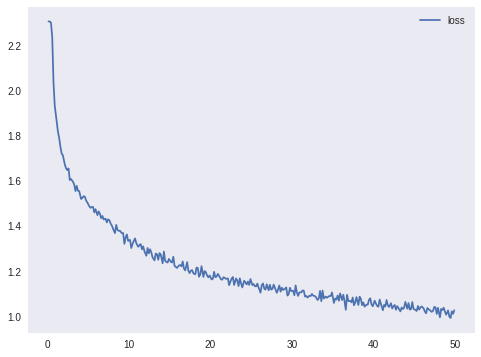

Loss: 1.0259653866291045
Accuracy: 0.6389322916666667


In [0]:
net = train(net,opt,criterion,50,256,trainset)

In [0]:
test(net,256,testset)

Accuracy on the test set: 0.639


Net with BlockConvs converges worse than baseline but it hasn't overfitted.

**Check mask**

In [0]:
print(net.conv4.mask.shape)
net.conv4.mask

torch.Size([30, 30, 3, 3])


Parameter containing:
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
        

### Basis for convolutional kernel

For each convolutional layer introduce a basis for convolutional kernel with the size 4 times lower than the number of filters, i.e.
each filter is represented as a liner combination of basis filters. Note, that filter in this context is a 3D tensor of shape [number of incoming channels, 3, 3] (order might differ depending on your framework).

In [0]:
class Conv2d_LC(nn.modules.conv._ConvNd):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(Conv2d_LC, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias)
        self.basis = Parameter(torch.empty([1,out_channels//4,in_channels,*kernel_size],requires_grad=True))
        self.coefficients = Parameter(torch.empty([out_channels,out_channels//4,1,1,1],requires_grad=True))
        nn.init.xavier_uniform_(self.basis)
        nn.init.xavier_uniform_(self.coefficients)
        del self.weight
        
    def LC(self):
        return torch.sum(self.coefficients*self.basis, dim=1).view(self.out_channels,self.in_channels,*self.kernel_size)
        
    def forward(self, input):
        return F.conv2d(input, self.LC(), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

In [0]:
class Network_ConvLC(nn.Module):
    def __init__(self, n):
        super(Network_ConvLC, self).__init__()
        self.conv1 = Conv2d_LC(3, n, 3)
        self.conv2 = Conv2d_LC(n, n, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = Conv2d_LC(n, int(1.5*n), 3)
        self.conv4 = Conv2d_LC(int(1.5*n), int(1.5*n), 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = Conv2d_LC(int(1.5*n), 2*n, 3)
        self.conv6 = Conv2d_LC(2*n, 2*n, 3)
        self.dense = nn.Linear(2*n, 10)
        self.nonlinearity = nn.LeakyReLU(negative_slope=0.01)
        self.apply(init_weights)

    def forward(self, x):
        x = self.nonlinearity(self.conv1(x))
        x = self.nonlinearity(self.conv2(x))
        x = self.pool1(x)
        x = self.nonlinearity(self.conv3(x))
        x = self.nonlinearity(self.conv4(x))
        x = self.pool2(x)
        x = self.nonlinearity(self.conv5(x))
        x = self.nonlinearity(self.conv6(x))
        # global pooling
        x = x.view(x.shape[0], x.shape[1], -1).mean(-1) # in this case H,W = 1, so it just reduces dims
        x = self.dense(x) #logits
        return x

In [0]:
net = Network_ConvLC(n)
net.device = device
net.to(net.device)
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

In [0]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(pytorch_total_params)

12495


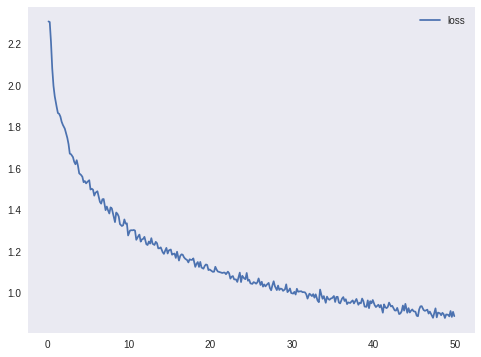

Loss: 0.8877493004004161
Accuracy: 0.688671875


In [0]:
net = train(net,opt,criterion,50,256,trainset)

In [0]:
test(net,256,testset)

Accuracy on the test set: 0.6397


### L1, L2 regularizations

In the previous exercise introduce a l1 regularization for decomposition coefficients and l2 regularization for the basis.

In [0]:
def criterion(logits,labels):
    loss = nn.CrossEntropyLoss()(logits,labels)
    for m in net.modules():
        if isinstance(m, Conv2d_LC):
            loss += c2*(m.basis.norm()**2) + c1*m.coefficients.norm(p=1)
    return loss

In [0]:
c1 = 5e-5
c2 = 5e-5
net = Network_ConvLC(n)
net.device = device
net.to(net.device)
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))

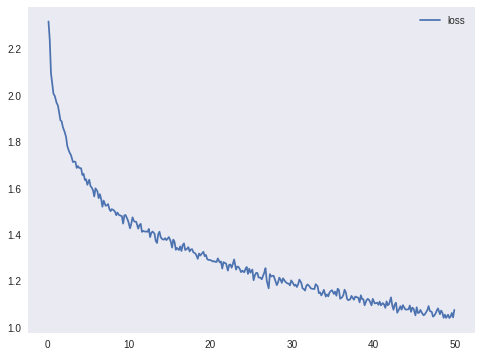

Loss: 1.0745136757691702
Accuracy: 0.626171875


In [19]:
net = train(net,opt,criterion,50,256,trainset)

In [20]:
test(net,256,testset)

Accuracy on the test set: 0.601


### Progressive regularization

Implement a progressive regularization by introducing different regularization coefficients to different filters, giving higher penalty to the higher positions, i.e: sum(coefs[:, None, None, None] * W ** 2) where:

- W - convolutional filter with dimensions [number of filters, number of incoming channels, width, height];
- coefs - ascending arrays of regularization coefficients.

Recommended options for regularization coefficients:

- coefs = C_0 * (range(k) + 1)
- coefs = C_0 * log(range(k) + 1)

Make sure that the total regularization in the initial state is lower that log 10 by approximately an order of magnitude. Use an ordinary regularization for the dense layer.

In [0]:
def criterion(logits,labels):
    loss = nn.CrossEntropyLoss()(logits,labels)
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            coeffs = C0 * torch.log(torch.arange(0,m.out_channels,dtype=torch.float32) + 1).view(m.out_channels,1,1,1)
            coeffs = coeffs.to(net.device)
            loss += (coeffs*m.weight).norm()**2
        if isinstance(m, nn.Linear):
            loss += C1 * (m.weight).norm()**2
    return loss

In [0]:
net = Network(n)
net.device = device
net.to(net.device)
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
C1 = 1e-3
C0 = 1e-2

In [53]:
def check(net):
    loss = 0.
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            coeffs = C0 * torch.log(torch.arange(0,m.out_channels,dtype=torch.float32) + 1).view(m.out_channels,1,1,1)
            coeffs = coeffs.to(net.device)
            loss += (coeffs*m.weight).norm()**2
        if isinstance(m, nn.Linear):
            loss += C1 * (m.weight).norm()**2
    return loss

print("Regularization in the initial state: " + str(check(net).data.cpu().numpy()))

Regularization in the initial state: 0.12831451


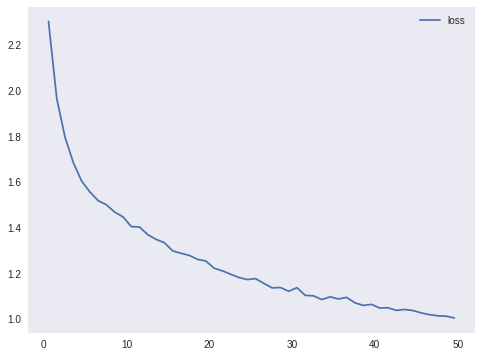

Loss: 1.00284499724706
Accuracy: 0.6864908854166667


In [54]:
net = train(net,opt,criterion,50,1024,trainset)

In [55]:
test(net,256,testset)

Accuracy on the test set: 0.6479
